# 1 

A partir del fichero "US_Crime_Rates_1960_2014", se pide:

1. Tratar el dataset como una serie temporal a partir de la columna Year. Siempre el eje X será el nuevo índice Year.
2. Dibujar todas las columnas numéricas.
3. Como se puede ver en el punto 2, la columna "Population" tiene una magnitud diferente a la de las demás columnas: Dibuja la misma gráfica que antes pero con dos resoluciones diferentes para que se puedan observar con mejor detalle todas las columnas. 
4. A partir de ahora y para el resto del ejercicio, borra las columnas "Population" y "Total" ¿Qué columnas tienen mejor correlación? 
5. A partir de las cinco columnas que tengan mejor correlación con la columna "Murder", entrena un modelo de regresión no lineal a partir de polinomio de grado 6. Este modelo ha de entrenarse siguiendo el esquema recomendado de validación cruzada y almacenando los errores de entrenamiento y validación en cada iteración del entrenamiento.
6. Representa la evolución de los errores de validación y entrenamiento en una gráfica. ¿Ha habido sobreaprendizaje?. Utiliza n_iteraciones=23 y n_repeats=7.

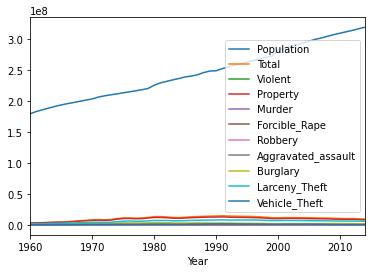

In [2]:
import pandas as pd
df = pd.read_csv("../data/US_Crime_Rates_1960_2014.csv")

df.set_index("Year", inplace=True)
df.plot()